## Import-import

In [140]:
# Basic
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler

# Model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import tensorflow as tf
import keras

from keras.models import Sequential
from keras.layers import LSTM, Dense
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Bidirectional, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping

In [141]:
train = pd.read_csv("train.csv")
train.shape

(13258, 16)

In [142]:
train_hourly = pd.read_csv("train_hourly.csv")
train_hourly.shape

(318192, 32)

In [143]:
test = pd.read_csv("test.csv")
test.shape

(4972, 16)

In [144]:
test_hourly = pd.read_csv("test_hourly.csv")
test_hourly.shape

(119328, 32)

In [145]:
city_dic = {'su' : '1', 'si' : '2', 'u' : '3', 'le' : '4', 'p' : '5', 'lh' : '6', 'b' : '7', 't' : '8', 'sa' : '9', 'q' : '10'}

# EDA

Pada train hourly, terdapat 170 baris yang berisi nilai null semua, maka dari itu baris-baris tsb akan didrop

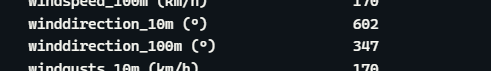

Kecuali untuk kedua kolom tersebut, akan diisi nilai rata2 berdasarkan tahun dan city-nya

In [146]:
def clean_train_hourly(df) :
    df['city'] = df['city'].map(city_dic)
    df.insert(1, 'date', df['time'].str[:10])
    df.insert(2, 'hour', df['time'].str[11:13])
    df['hour'] = df['hour'].astype('int')

    # Kolom year hanya diperlukan untuk handle missing value
    df['year'] = pd.to_datetime(df['date']).dt.year
    df.drop('time', axis=1, inplace=True)

    df['winddirection_10m (°)'] = df['winddirection_10m (°)'].fillna(df.groupby(['city', 'year'])['winddirection_10m (°)'].transform('median'))
    df['winddirection_100m (°)'] = df['winddirection_100m (°)'].fillna(df.groupby(['city', 'year'])['winddirection_100m (°)'].transform('median'))
    df.drop('year', axis=1, inplace=True)

Selain kedua kolom itu, data akan didrop karena memang baris-barisnya kosonggg (data tahun 2022)

In [147]:
clean_train_hourly(train_hourly)
train_hourly = train_hourly.dropna()
train_hourly.head(1)

,date,hour,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),city
0,2018-01-01,0,25.0,94.0,24.1,32.3,1007.0,1009.3,0.0,82.0,...,0.18,26.8,28.5,28.7,29.3,0.298,0.307,0.281,0.28,1


In [148]:
def clean_test_hourly(df) :
    df['city'] = df['city'].map(city_dic)
    df.insert(1, 'date', df['time'].str[:10])
    df.insert(2, 'hour', df['time'].str[11:13])
    df['hour'] = df['hour'].astype('int')
    df.drop('time', axis=1, inplace=True)

In [149]:
clean_test_hourly(test_hourly)
test_hourly = test_hourly.dropna()
test_hourly.head(1)

,date,hour,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),city
0,2021-08-02,0,26.1,73.0,21.0,31.0,1010.9,1013.2,0.0,5.0,...,0.9,27.4,30.7,29.2,28.6,0.056,0.078,0.113,0.234,1


In [150]:
train.rename(columns={'time': 'date'}, inplace=True)
train['city'] = train['city'].map(city_dic)

In [151]:
train_hourly_agg = train_hourly.groupby(['date', 'city']).agg('mean').reset_index()
train_hourly_agg = train_hourly_agg.drop('hour', axis=1)
train_hourly_agg.head(1)

,date,city,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2018-01-01,1,26.404167,87.0,24.058333,33.604167,1006.483333,1008.783333,0.0,73.041667,...,0.150417,0.4625,28.529167,28.591667,28.7,29.270833,0.297917,0.300292,0.282667,0.28


In [152]:
test.rename(columns={'time': 'date'}, inplace=True)
test['city'] = test['city'].map(city_dic)
test.drop('id', axis=1, inplace=True)

In [153]:
test_hourly_agg = test_hourly.groupby(['date', 'city']).agg('mean').reset_index()
test_hourly_agg = test_hourly_agg.drop('hour', axis=1)
test_hourly_agg.head(1)


,date,city,temperature_2m (°C),relativehumidity_2m (%),dewpoint_2m (°C),apparent_temperature (°C),pressure_msl (hPa),surface_pressure (hPa),snowfall (cm),cloudcover (%),...,et0_fao_evapotranspiration (mm),vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2021-08-02,1,28.129167,65.166667,20.5875,33.25,1011.025,1013.325,0.0,13.625,...,0.185417,1.423333,31.445833,30.625,29.233333,28.6,0.0565,0.0775,0.1125,0.234


In [154]:
train['is_snowing'] = train['snowfall_sum (cm)'].apply(lambda x: 1 if x > 0 else 0)
train.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),elevation,city,is_snowing
0,2018-01-01,29.9,26.0,36.3,31.6,2018-01-01T05:15,2018-01-01T17:49,17.59,7.7,0.0,6.9,20.2,277.0,3.61,0,1,0


In [155]:
test['is_snowing'] = test['snowfall_sum (cm)'].apply(lambda x: 1 if x > 0 else 0)
test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm),elevation,city,is_snowing
0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.0,7.6,16.9,134.0,4.45,0,1,0


In [156]:
merged_train = pd.merge(train, train_hourly_agg,
                        how='outer', on=['date', 'city'])

# Handling missing values on train data
merged_train['year'] = pd.to_datetime(merged_train['date']).dt.year
merged_train['winddirection_10m_dominant (°)'] = merged_train['winddirection_10m_dominant (°)'].fillna(merged_train.groupby(['city', 'year'])['winddirection_10m_dominant (°)'].transform('median'))
merged_train = merged_train.dropna()
# merged_train.insert(1, 'day_month', merged_train['date'].str[5:10])
# merged_train = merged_train.drop('date', axis=1)
merged_train = merged_train.drop('year', axis=1)

merged_train.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),...,et0_fao_evapotranspiration (mm)_y,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2018-01-01,29.9,26.0,36.3,31.6,2018-01-01T05:15,2018-01-01T17:49,17.59,7.7,0.0,...,0.150417,0.4625,28.529167,28.591667,28.7,29.270833,0.297917,0.300292,0.282667,0.28


In [157]:
merged_test = pd.merge(test, test_hourly_agg, how='outer', on=['date', 'city'])
merged_test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),...,et0_fao_evapotranspiration (mm)_y,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.0,7.6,...,0.185417,1.423333,31.445833,30.625,29.233333,28.6,0.0565,0.0775,0.1125,0.234


In [158]:
# merged_test.insert(1, 'day_month', merged_test['date'].str[5:10])
# merged_test = merged_test.drop('date', axis=1)
merged_test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),sunrise (iso8601),sunset (iso8601),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),...,et0_fao_evapotranspiration (mm)_y,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³)
0,2021-08-02,32.3,25.3,38.2,29.6,2021-08-02T05:39,2021-08-02T17:30,20.79,0.0,7.6,...,0.185417,1.423333,31.445833,30.625,29.233333,28.6,0.0565,0.0775,0.1125,0.234


In [159]:
def sunrise_sunset(df) :
    # Pisah jam dan menit
    df.insert(4, 'sunrise (hour)', df['sunrise (iso8601)'].str[11:13])
    df['sunrise (hour)'] = df['sunrise (hour)'].astype('int')

    df.insert(5, 'sunrise (minute)', df['sunrise (iso8601)'].str[14:])
    df['sunrise (minute)'] = df['sunrise (minute)'].astype('int')

    df.insert(6, 'sunset (hour)', df['sunset (iso8601)'].str[11:13])
    df['sunset (hour)'] = df['sunset (hour)'].astype('int')

    df.insert(7, 'sunset (minute)', df['sunset (iso8601)'].str[14:])
    df['sunset (minute)'] = df['sunset (minute)'].astype('int')

    # Drop kolom awal
    df.drop(['sunrise (iso8601)', 'sunset (iso8601)'], axis=1, inplace=True)

    # Get selisih sunrise-sunset
    df['sunrise_time'] = df['sunrise (hour)'].astype(str) + ':' + df['sunrise (minute)'].astype(str)
    df['sunset_time'] = df['sunset (hour)'].astype(str) + ':' + df['sunset (minute)'].astype(str)

    df['sunrise_time'] = pd.to_datetime(df['sunrise_time'], format='%H:%M')
    df['sunset_time'] = pd.to_datetime(df['sunset_time'], format='%H:%M')

    df['sunrise_to_sunset'] = (df['sunset_time'] - df['sunrise_time']).dt.total_seconds() / 3600

    df = df.drop(['sunrise (hour)', 'sunrise (minute)', 'sunset (hour)','sunset (minute)', 'sunrise_time', 'sunset_time'], axis=1, inplace=True)

In [160]:
sunrise_sunset(merged_train)
merged_train.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),rain_sum (mm),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset
0,2018-01-01,29.9,26.0,36.3,31.6,17.59,7.7,0.0,6.9,20.2,...,0.4625,28.529167,28.591667,28.7,29.270833,0.297917,0.300292,0.282667,0.28,12.566667


In [161]:
sunrise_sunset(merged_test)
merged_test.head(1)

,date,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset
0,2021-08-02,32.3,25.3,38.2,29.6,20.79,0.0,7.6,16.9,134.0,...,1.423333,31.445833,30.625,29.233333,28.6,0.0565,0.0775,0.1125,0.234,11.85


In [162]:
# Memisahkan data yang tidak di-scale
keep = merged_train[['date', 'city', 'is_snowing', 'rain_sum (mm)']]
merged_train = merged_train.drop(['date', 'city', 'is_snowing',  'rain_sum (mm)'], axis=1)

In [163]:
train_stand = StandardScaler()
train_normal = MinMaxScaler()
train_robust = RobustScaler()

fit_train_robust = train_robust.fit_transform(merged_train)
train_robust = pd.DataFrame(columns=merged_train.columns, index=merged_train.index, data=fit_train_robust)

fit_train_std = train_stand.fit_transform(train_robust)
train_std = pd.DataFrame(columns=train_robust.columns, index=train_robust.index, data=fit_train_std)

fit_train_normal = train_normal.fit_transform(train_std)
train_normal = pd.DataFrame(columns=train_std.columns, index=train_std.index, data=fit_train_normal)
train_normal.head(1)

,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset
0,0.869376,0.959612,0.877778,0.96011,0.542566,0.0,0.072027,0.109477,0.769444,0.473753,...,0.2187,0.893182,0.905715,0.929825,0.957341,0.644171,0.632397,0.585039,0.534251,0.925573


In [164]:
train_scaled = pd.concat([train_normal, keep], axis=1)
train_scaled.head(1)


,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset,date,city,is_snowing,rain_sum (mm)
0,0.869376,0.959612,0.877778,0.96011,0.542566,0.0,0.072027,0.109477,0.769444,0.473753,...,0.957341,0.644171,0.632397,0.585039,0.534251,0.925573,2018-01-01,1,0,7.7


In [165]:
# Memisahkan data yang tidak di-scale
keep = merged_test[['date', 'city', 'is_snowing']]
merged_test = merged_test.drop(
    ['date', 'city', 'is_snowing'], axis=1)


In [166]:
test_stand = StandardScaler()
test_normal = MinMaxScaler()
test_robust = RobustScaler()

fit_test_robust = test_robust.fit_transform(merged_test)
test_robust = pd.DataFrame(columns=merged_test.columns, index=merged_test.index, data=fit_test_robust)

fit_test_std = test_stand.fit_transform(test_robust)
test_std = pd.DataFrame(columns=test_robust.columns, index=test_robust.index, data=fit_test_std)

fit_test_normal = test_normal.fit_transform(test_std)
test_normal = pd.DataFrame(columns=test_std.columns, index=test_std.index, data=fit_test_normal)
test_normal.head(1)

,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,vapor_pressure_deficit (kPa),soil_temperature_0_to_7cm (°C),soil_temperature_7_to_28cm (°C),soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset
0,0.931638,0.956835,0.921438,0.939079,0.642857,0.0,0.097701,0.140715,0.372222,0.706349,...,0.716211,0.96043,0.960003,0.962571,0.969365,0.085616,0.073812,0.124869,0.399779,0.90537


In [167]:
test_scaled = pd.concat([test_normal, keep], axis=1)
test_scaled.head(1)

,temperature_2m_max (°C),temperature_2m_min (°C),apparent_temperature_max (°C),apparent_temperature_min (°C),shortwave_radiation_sum (MJ/m²),snowfall_sum (cm),windspeed_10m_max (km/h),windgusts_10m_max (km/h),winddirection_10m_dominant (°),et0_fao_evapotranspiration (mm)_x,...,soil_temperature_28_to_100cm (°C),soil_temperature_100_to_255cm (°C),soil_moisture_0_to_7cm (m³/m³),soil_moisture_7_to_28cm (m³/m³),soil_moisture_28_to_100cm (m³/m³),soil_moisture_100_to_255cm (m³/m³),sunrise_to_sunset,date,city,is_snowing
0,0.931638,0.956835,0.921438,0.939079,0.642857,0.0,0.097701,0.140715,0.372222,0.706349,...,0.962571,0.969365,0.085616,0.073812,0.124869,0.399779,0.90537,2021-08-02,1,0


# Feature Selection

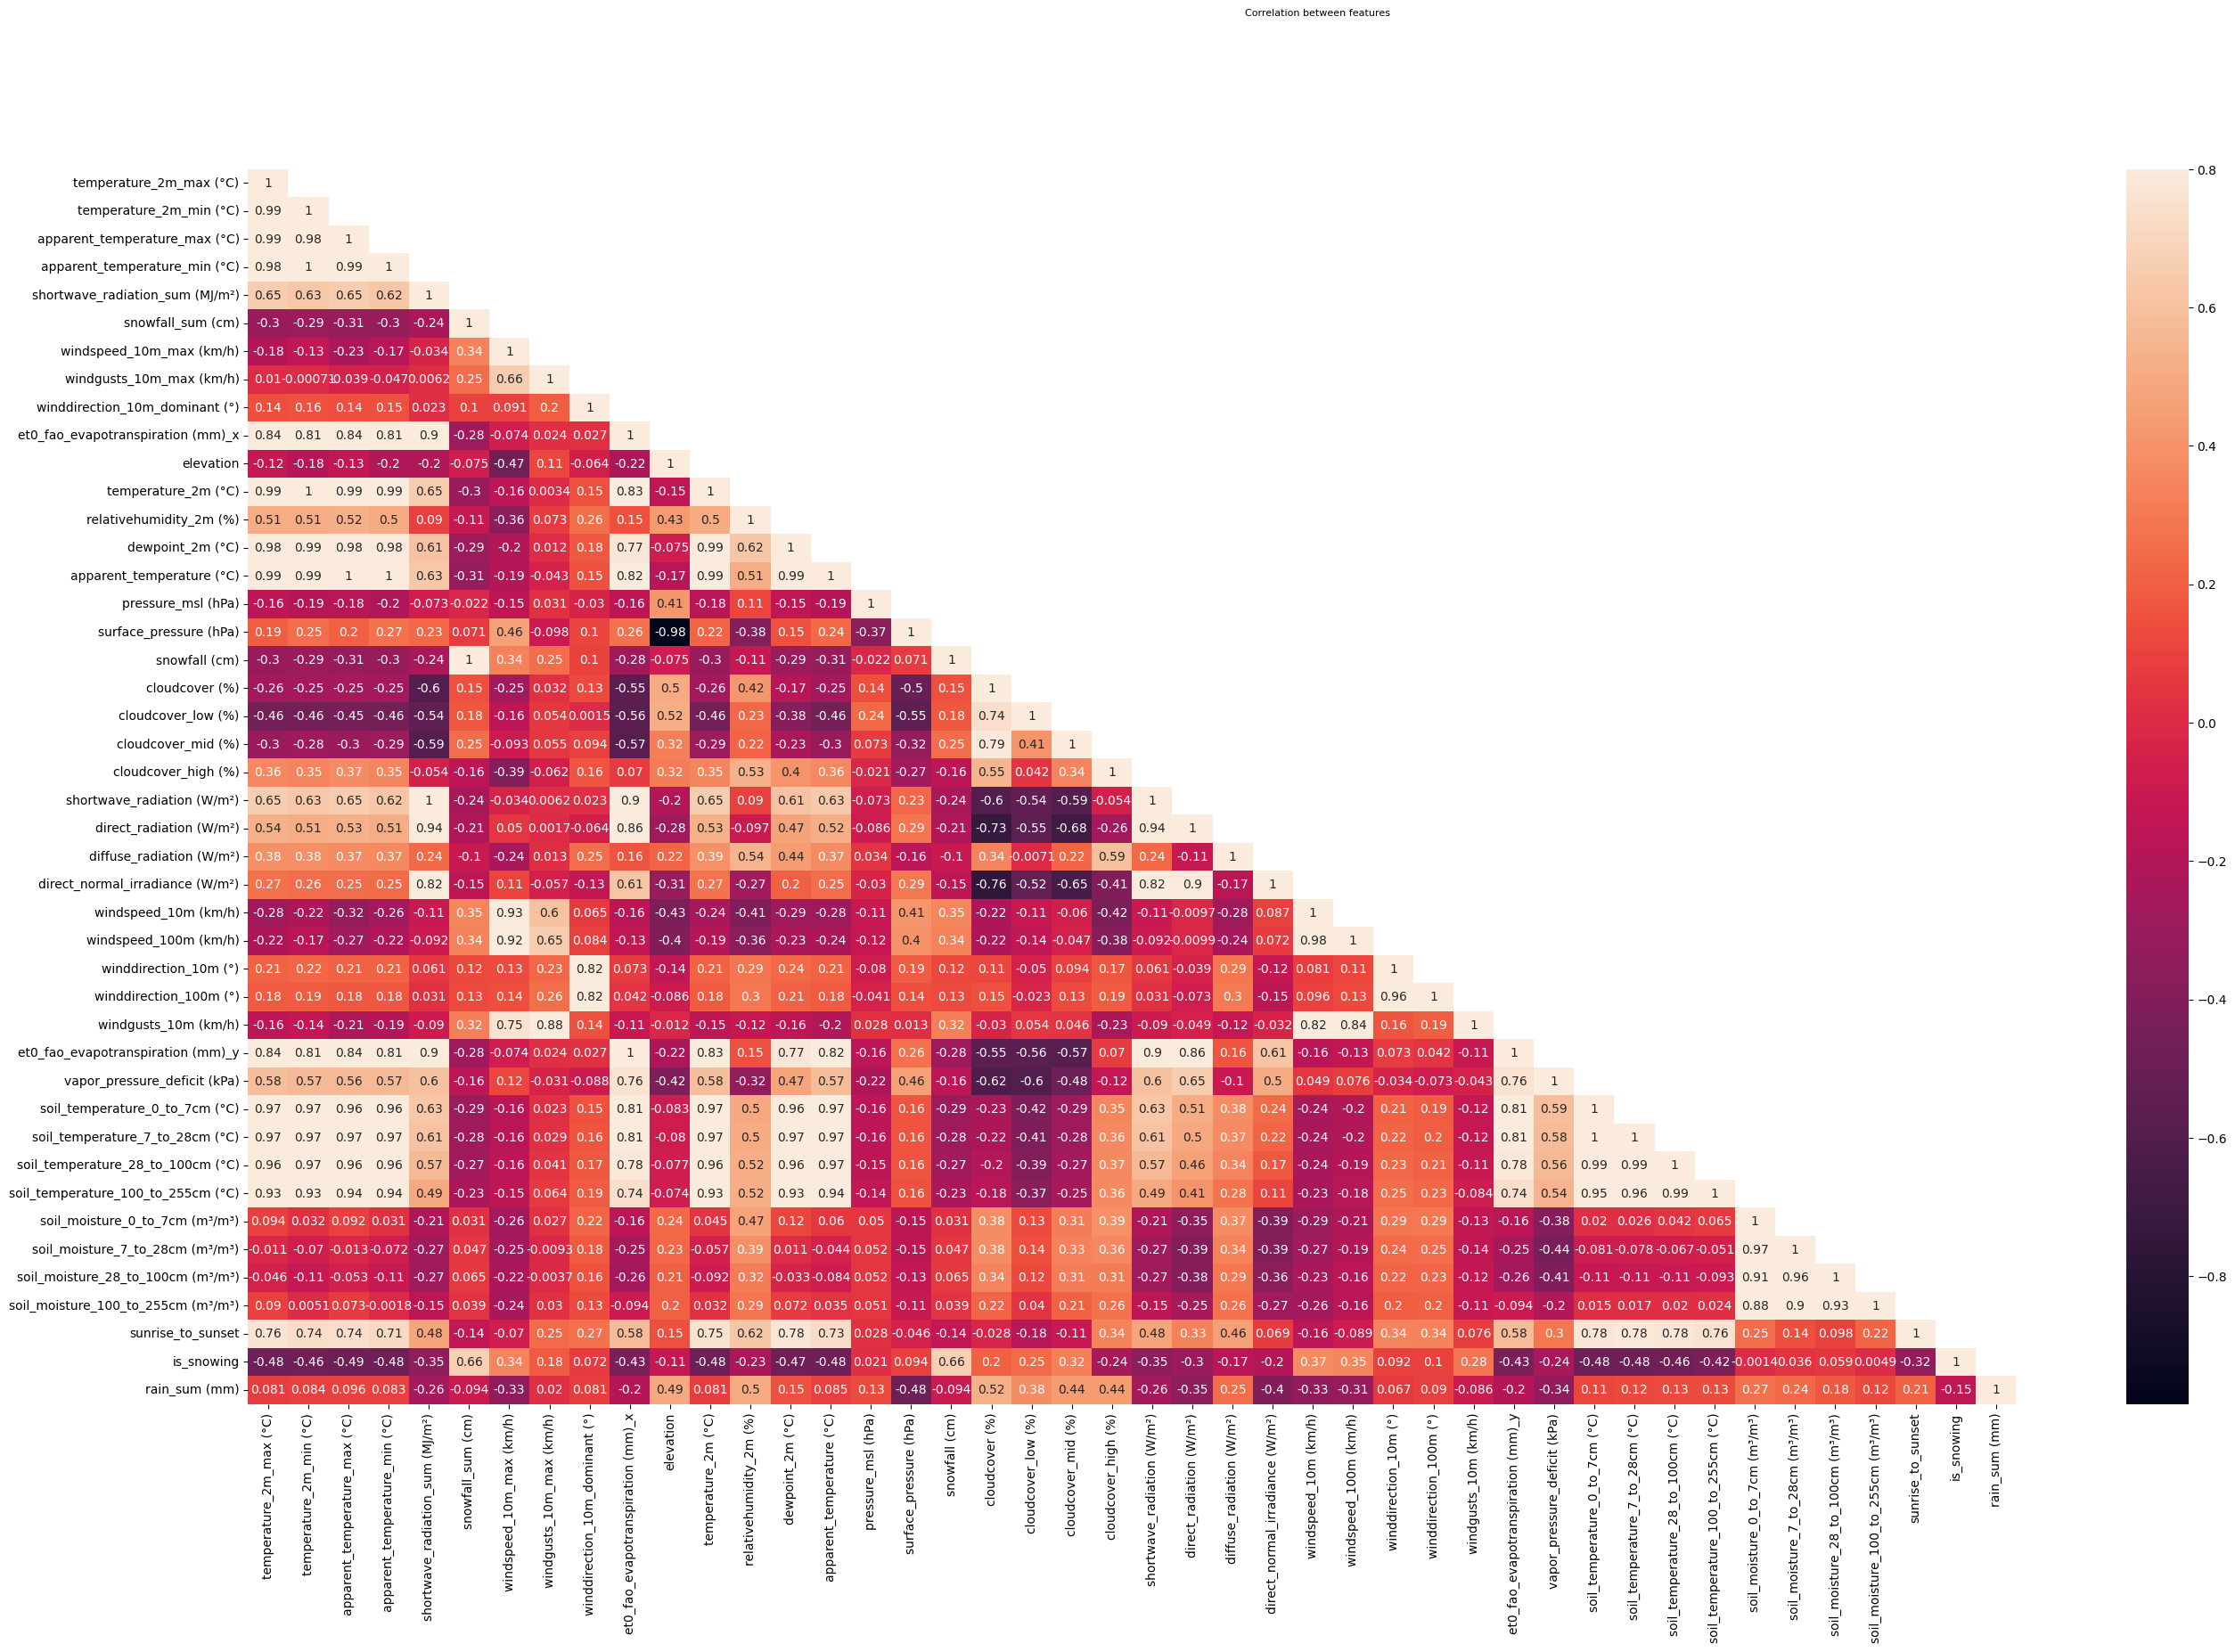

In [168]:
corrcoef = train_scaled.corr()

fig,ax = plt.subplots(figsize=(32,18)) 
fig.suptitle("Correlation between features", fontsize=8)
mask = np.array(corrcoef)
mask[np.tril_indices_from(mask)] = False
sns.heatmap(corrcoef, mask=mask, vmax=.8, annot=True, ax=ax)
plt.show()

In [169]:
highest_corr = corrcoef['rain_sum (mm)'].abs().sort_values(ascending=False)
highest_corr = highest_corr.keys().tolist()

In [170]:
top = highest_corr[0:21]
top

['rain_sum (mm)',
 'cloudcover (%)',
 'relativehumidity_2m (%)',
 'elevation',
 'surface_pressure (hPa)',
 'cloudcover_mid (%)',
 'cloudcover_high (%)',
 'direct_normal_irradiance (W/m²)',
 'cloudcover_low (%)',
 'direct_radiation (W/m²)',
 'vapor_pressure_deficit (kPa)',
 'windspeed_10m (km/h)',
 'windspeed_10m_max (km/h)',
 'windspeed_100m (km/h)',
 'soil_moisture_0_to_7cm (m³/m³)',
 'shortwave_radiation (W/m²)',
 'shortwave_radiation_sum (MJ/m²)',
 'diffuse_radiation (W/m²)',
 'soil_moisture_7_to_28cm (m³/m³)',
 'sunrise_to_sunset',
 'et0_fao_evapotranspiration (mm)_y']

In [171]:
top.append('is_snowing')
train_final = train_scaled[top]
train_final.insert(0, 'date', train_scaled['date'])
train_final.head(1)

,date,rain_sum (mm),cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),...,windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,is_snowing
0,2018-01-01,7.7,0.730417,0.798571,0.0,0.925065,0.290417,0.907917,0.197808,0.319631,...,0.072027,0.038542,0.644171,0.542527,0.542566,0.519873,0.632397,0.925573,0.473753,0


In [172]:
top_test = top.copy()
top_test.remove('rain_sum (mm)')
test_final = test_scaled[top_test]
test_final.insert(0, 'date', train_scaled['date'])
test_final.head(1)

,date,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,is_snowing
0,2018-01-01,0.13625,0.450593,0.0,0.952183,0.093072,0.026667,0.373827,0.081563,0.617488,...,0.097701,0.089102,0.085616,0.642953,0.642857,0.235847,0.073812,0.90537,0.706349,0


In [173]:
# train_scaled.to_csv('full_train_final.csv')
# test_scaled.to_csv('full_test_final.csv')

In [174]:
# train_final.to_csv('20_train_final.csv')
# test_final.to_csv('20_test_final.csv')

# Model

In [175]:
train_final = train_final.set_index('date')
train_final.head(1)

,rain_sum (mm),cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,is_snowing
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,7.7,0.730417,0.798571,0.0,0.925065,0.290417,0.907917,0.197808,0.319631,0.339211,...,0.072027,0.038542,0.644171,0.542527,0.542566,0.519873,0.632397,0.925573,0.473753,0


In [176]:
test_final = test_final.set_index('date')
test_final.head(1)

,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),vapor_pressure_deficit (kPa),...,windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,is_snowing
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.13625,0.450593,0.0,0.952183,0.093072,0.026667,0.373827,0.081563,0.617488,0.716211,...,0.097701,0.089102,0.085616,0.642953,0.642857,0.235847,0.073812,0.90537,0.706349,0


In [179]:
X = train_final.drop('rain_sum (mm)', axis=1)
y = train_final['rain_sum (mm)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=101)

X_train = X_train.to_numpy().reshape((X_train.shape[0],  X_train.shape[1], 1))
X_test = X_test.to_numpy().reshape((X_test.shape[0],  X_test.shape[1], 1))

In [184]:
from keras.callbacks import ModelCheckpoint, TensorBoard, Callback, EarlyStopping
early_stop = EarlyStopping(monitor = "loss", mode = "min", patience = 7)
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Bidirectional(LSTM(128, return_sequences=False, activation='relu')))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train,y_train,epochs=200, verbose=1, callbacks = [early_stop], validation_data=(X_test, y_test))

Epoch 1/200
369/369 [==============================] - 104s 252ms/step - loss: 133.9691 - val_loss: 63.9749
Epoch 2/200
369/369 [==============================] - 72s 196ms/step - loss: 56.8379 - val_loss: 38.9762
Epoch 3/200
369/369 [==============================] - 73s 197ms/step - loss: 48.1760 - val_loss: 34.0811
Epoch 4/200
369/369 [==============================] - 74s 200ms/step - loss: 46.0500 - val_loss: 36.2507
Epoch 5/200
369/369 [==============================] - 72s 194ms/step - loss: 50.5623 - val_loss: 89.2388
Epoch 6/200
369/369 [==============================] - 72s 194ms/step - loss: 89.4782 - val_loss: 71.6819
Epoch 7/200
369/369 [==============================] - 75s 203ms/step - loss: 83694141440.0000 - val_loss: 71.0927
Epoch 8/200
369/369 [==============================] - 74s 201ms/step - loss: 86.5746 - val_loss: 70.9038
Epoch 9/200
369/369 [==============================] - 73s 197ms/step - loss: 86.3233 - val_loss: 70.0952
Epoch 10/200
369/369 [=============

In [ ]:
early_stop = EarlyStopping(monitor = "loss", mode = "min", patience = 7)
model = Sequential()
model.add(LSTM(units=100, return_sequences=True, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(LSTM(units=100, return_sequences=True, activation='relu'))
model.add(Bidirectional(LSTM(128, return_sequences=False, activation='relu')))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(X_train,y_train,epochs=200, verbose=1, callbacks = [early_stop], validation_data=(X_test, y_test))

In [ ]:
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD

In [ ]:
# # The LSTM architecture
# regressor = Sequential()
# # First LSTM layer with Dropout regularisation
# regressor.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# regressor.add(Dropout(0.2))
# # Second GRU layer
# regressor.add(GRU(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='tanh'))
# regressor.add(Dropout(0.2))
# # The output layer
# regressor.add(Dense(units=1))

# # Compiling the RNN
# regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# # Fitting to the training set
# regressor.fit(X_train,y_train,epochs=10,batch_size=32)

In [ ]:
# # Define the model
# model = keras.Sequential()
# model.add(keras.layers.LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(keras.layers.Dense(1))

# # Compile the model
# model.compile(loss='mean_squared_error', optimizer='adam')

# # Fit the model to the training data
# model.fit(X_train, y_train, epochs=100, batch_size=32)

# # Use the model to make predictions on new data
# y_pred = model.predict(X_test)

In [ ]:
test = test_final.to_numpy().reshape((test_final.shape[0],  test_final.shape[1], 1))
predictions = model.predict(test)

156/156 [==============================] - 6s 28ms/step


In [ ]:
predictions.shape

(4972, 1)

In [ ]:
predictions2 = predictions.reshape((predictions.shape[0],))

In [ ]:
result = pd.DataFrame({'rain_sum (mm)' : predictions2})

In [ ]:
result

,rain_sum (mm)
0,0.011703
1,0.043470
2,0.058436
3,0.201517
4,0.449116
...,...
4967,3.872566
4968,5.911194
4969,0.528746
4970,0.766990


In [ ]:
result['rain_sum (mm)'] = result['rain_sum (mm)'].apply(lambda x: 0 if x < 0 else x)

In [ ]:
result[result['rain_sum (mm)'] < 0]

,rain_sum (mm)


In [ ]:
result['rain_sum (mm)'].max()

26.060300827026367

In [ ]:
result['rain_sum (mm)'].mean()

4.197364182317103

In [ ]:
result.head()

,rain_sum (mm)
0,0.046006
1,0.046006
2,0.046006
3,0.046006
4,0.046006


In [ ]:
test_final.head()

,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),vapor_pressure_deficit (kPa),...,windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,is_snowing
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01,0.136250,0.450593,0.0,0.952183,0.093072,0.026667,0.373827,0.081563,0.617488,0.716211,...,0.097701,0.089102,0.085616,0.642953,0.642857,0.235847,0.073812,0.90537,0.706349,0
2018-01-02,0.205000,0.511199,0.0,0.955921,0.192821,0.124583,0.343263,0.059473,0.569625,0.639158,...,0.147510,0.119778,0.095829,0.618682,0.618738,0.267760,0.070229,0.90537,0.685714,0
2018-01-03,0.166667,0.528327,0.0,0.956826,0.065526,0.234167,0.380366,0.063721,0.621170,0.621053,...,0.283525,0.205205,0.092584,0.646181,0.645949,0.236066,0.066544,0.90537,0.750794,0
2018-01-04,0.217500,0.534914,0.0,0.957979,0.051753,0.533333,0.408646,0.029737,0.676660,0.616211,...,0.254789,0.199805,0.090198,0.686150,0.686147,0.222295,0.063984,0.90537,0.787302,0
2018-01-05,0.287083,0.552701,0.0,0.956578,0.022538,0.848333,0.390094,0.021665,0.647469,0.591368,...,0.339080,0.260407,0.088480,0.675351,0.675325,0.249617,0.061323,0.90581,0.792063,0


In [ ]:
merge_result = pd.concat([test_final.reset_index(), result], axis=1)

In [ ]:
merge_result[merge_result['rain_sum (mm)'] == merge_result['rain_sum (mm)'].max()]

,date,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,is_snowing,rain_sum (mm)
1443,2018-05-06,1.0,0.886034,0.000000,0.852022,0.896494,0.995833,0.018702,0.783347,0.042078,...,0.113403,0.205498,0.211200,0.211194,0.344699,0.148239,0.918574,0.228571,0,0.046458
3090,2019-03-25,1.0,0.921607,0.519417,0.479705,0.828047,0.966667,0.038318,0.660153,0.071795,...,0.150379,0.910471,0.258294,0.258194,0.387760,0.921785,0.910211,0.257143,0,0.046458
3261,2019-09-12,1.0,0.891304,0.519417,0.477719,0.815526,0.995000,0.046312,0.699235,0.093886,...,0.172804,0.905507,0.275328,0.275201,0.384481,0.914619,0.916373,0.279365,0,0.046458
3368,2019-12-28,1.0,0.940711,0.519417,0.481983,0.935309,0.973750,0.019675,0.709431,0.034320,...,0.158329,0.930992,0.210978,0.210884,0.357158,0.937244,0.915053,0.222222,0,0.046458
3399,2020-01-28,1.0,0.867589,0.519417,0.480727,0.799666,0.993750,0.024085,0.734919,0.045628,...,0.237606,0.932996,0.253062,0.252938,0.420984,0.938268,0.912852,0.242857,0,0.046458
3426,2020-02-24,1.0,0.905138,0.519417,0.486013,0.842654,0.994167,0.081639,0.621495,0.154504,...,0.081527,0.917725,0.387887,0.387755,0.504699,0.918509,0.910651,0.371429,0,0.046458
3433,2020-03-02,1.0,0.939394,0.519417,0.489429,0.897746,0.998750,0.025240,0.676296,0.046811,...,0.150604,0.917438,0.255511,0.255411,0.423825,0.926699,0.910211,0.253968,0,0.046458
3440,2020-03-09,1.0,0.954545,0.519417,0.483691,0.857262,0.996667,0.029741,0.955395,0.051677,...,0.060377,0.919252,0.183923,0.183983,0.275191,0.922297,0.909771,0.192063,0,0.046458
3441,2020-03-10,1.0,0.989460,0.519417,0.483925,0.965776,0.999167,0.014785,0.887426,0.029717,...,0.056776,0.927937,0.160098,0.160173,0.264918,0.928952,0.909771,0.180952,0,0.046458
3464,2020-04-02,1.0,0.947299,0.519417,0.482684,0.823038,0.987917,0.029216,0.739592,0.052465,...,0.163804,0.943400,0.236362,0.236240,0.376831,0.931818,0.908891,0.246032,0,0.046458


In [ ]:
train_final[train_final['rain_sum (mm)'] == train_final['rain_sum (mm)'].max()].reset_index()

,date,rain_sum (mm),cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),...,windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,is_snowing
0,2020-01-25,182.7,0.951667,0.939571,0.0,0.873556,0.942917,0.9975,0.001025,0.572987,...,0.092127,0.096031,0.992701,0.037753,0.037631,0.07404,0.99149,0.922977,0.062992,0


In [ ]:
merge_result.groupby('is_snowing').mean()

,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),vapor_pressure_deficit (kPa),...,windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,rain_sum (mm)
is_snowing,,,,,,,,,,,,,,,,,,,,,
0,0.591332,0.754006,0.157691,0.765771,0.328709,0.694971,0.234595,0.264861,0.390155,0.213627,...,0.157974,0.131600,0.661866,0.522059,0.521959,0.376395,0.646745,0.881295,0.526059,0.045938
1,0.774165,0.576431,0.002934,0.867834,0.659965,0.282457,0.123388,0.487280,0.111703,0.052884,...,0.331403,0.292899,0.582181,0.202565,0.202536,0.212007,0.577159,0.631235,0.109842,0.044810


In [ ]:
train_final.groupby('is_snowing').mean()

,rain_sum (mm),cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,windspeed_10m (km/h),windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y
is_snowing,,,,,,,,,,,,,,,,,,,,,
0,6.622977,0.558128,0.743544,0.164360,0.752167,0.289759,0.630887,0.253227,0.270169,0.420299,...,0.132314,0.142148,0.134589,0.629411,0.542654,0.542679,0.379135,0.620188,0.883561,0.453566
1,0.583541,0.781106,0.577704,0.003415,0.868248,0.639976,0.268009,0.126485,0.501463,0.121948,...,0.307518,0.297333,0.300133,0.627619,0.239172,0.239184,0.277163,0.665629,0.687303,0.107187


In [ ]:
train_final[train_final['rain_sum (mm)'] == train_final['rain_sum (mm)'].max()]


,rain_sum (mm),cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,windspeed_10m_max (km/h),windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,is_snowing
date,,,,,,,,,,,,,,,,,,,,,
2020-01-25,182.7,0.951667,0.939571,0.0,0.873556,0.942917,0.9975,0.001025,0.572987,0.001829,...,0.092127,0.096031,0.992701,0.037753,0.037631,0.07404,0.99149,0.922977,0.062992,0


In [ ]:
merge_result[merge_result['rain_sum (mm)'] == merge_result['rain_sum (mm)'].max()]

,date,cloudcover (%),relativehumidity_2m (%),elevation,surface_pressure (hPa),cloudcover_mid (%),cloudcover_high (%),direct_normal_irradiance (W/m²),cloudcover_low (%),direct_radiation (W/m²),...,windspeed_100m (km/h),soil_moisture_0_to_7cm (m³/m³),shortwave_radiation (W/m²),shortwave_radiation_sum (MJ/m²),diffuse_radiation (W/m²),soil_moisture_7_to_28cm (m³/m³),sunrise_to_sunset,et0_fao_evapotranspiration (mm)_y,is_snowing,rain_sum (mm)
1443,2018-05-06,1.0,0.886034,0.000000,0.852022,0.896494,0.995833,0.018702,0.783347,0.042078,...,0.113403,0.205498,0.211200,0.211194,0.344699,0.148239,0.918574,0.228571,0,0.046458
3090,2019-03-25,1.0,0.921607,0.519417,0.479705,0.828047,0.966667,0.038318,0.660153,0.071795,...,0.150379,0.910471,0.258294,0.258194,0.387760,0.921785,0.910211,0.257143,0,0.046458
3261,2019-09-12,1.0,0.891304,0.519417,0.477719,0.815526,0.995000,0.046312,0.699235,0.093886,...,0.172804,0.905507,0.275328,0.275201,0.384481,0.914619,0.916373,0.279365,0,0.046458
3368,2019-12-28,1.0,0.940711,0.519417,0.481983,0.935309,0.973750,0.019675,0.709431,0.034320,...,0.158329,0.930992,0.210978,0.210884,0.357158,0.937244,0.915053,0.222222,0,0.046458
3399,2020-01-28,1.0,0.867589,0.519417,0.480727,0.799666,0.993750,0.024085,0.734919,0.045628,...,0.237606,0.932996,0.253062,0.252938,0.420984,0.938268,0.912852,0.242857,0,0.046458
3426,2020-02-24,1.0,0.905138,0.519417,0.486013,0.842654,0.994167,0.081639,0.621495,0.154504,...,0.081527,0.917725,0.387887,0.387755,0.504699,0.918509,0.910651,0.371429,0,0.046458
3433,2020-03-02,1.0,0.939394,0.519417,0.489429,0.897746,0.998750,0.025240,0.676296,0.046811,...,0.150604,0.917438,0.255511,0.255411,0.423825,0.926699,0.910211,0.253968,0,0.046458
3440,2020-03-09,1.0,0.954545,0.519417,0.483691,0.857262,0.996667,0.029741,0.955395,0.051677,...,0.060377,0.919252,0.183923,0.183983,0.275191,0.922297,0.909771,0.192063,0,0.046458
3441,2020-03-10,1.0,0.989460,0.519417,0.483925,0.965776,0.999167,0.014785,0.887426,0.029717,...,0.056776,0.927937,0.160098,0.160173,0.264918,0.928952,0.909771,0.180952,0,0.046458
3464,2020-04-02,1.0,0.947299,0.519417,0.482684,0.823038,0.987917,0.029216,0.739592,0.052465,...,0.163804,0.943400,0.236362,0.236240,0.376831,0.931818,0.908891,0.246032,0,0.046458


In [ ]:
train_final['rain_sum (mm)'].mean()

6.290112822076538

In [ ]:
result.insert(0, 'id', result.index)
result = result.set_index('id')

In [ ]:
result

,rain_sum (mm)
id,
0,0.046006
1,0.046006
2,0.046006
3,0.046006
4,0.046006
...,...
4967,0.044778
4968,0.045343
4969,0.044778


In [ ]:
# result.to_csv('percobaan_pake_date.csv')